# ASTR 596: FDS Homework 6+7: Gaussian Processes (200 pts)

### This is a double HW set so you get extra time - until reading day (May 4th, 2023) at noon to do it. 
### After that, it's finals time. 


# P1. Gaussian Processes

### Last HW, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [1]:
from astropy.table import Table
import scipy.stats as st
import sklearn
import sklearn.ensemble
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import george
import emcee

In [2]:
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab

time,flux,error,quarter
float64,float64,float64,int64
539.4710179205795,5221.16455078125,4.891251087188721,6
539.4914521464307,5216.07958984375,4.892819404602051,6
...,...,...,...
905.8861516335674,5868.67822265625,4.119019031524658,9
905.9065858290269,5864.173828125,4.119871616363525,9
905.9270202242624,5861.61572265625,4.119407653808594,9


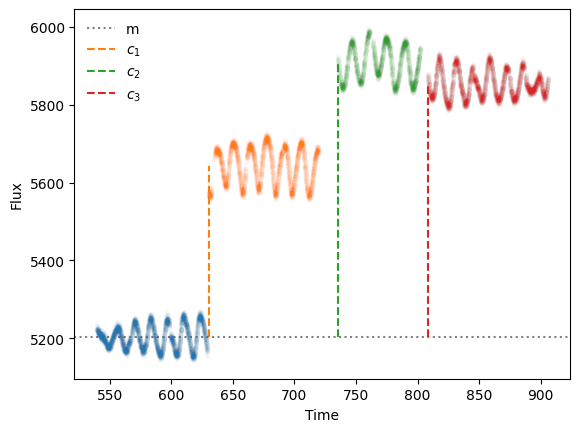

In [3]:
qs = sorted(np.unique(tab['quarter']))
plt.figure()
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    if i == 0:
        plt.axhline(meanflux, label='m', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False);


### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations. (20 pts)

The kernels implemented in ```george```:

```george.kernels.ExpSquaredKernel(metric=None, metric_bounds=None, lower=True, block=None, bounds=None, ndim=1, axes=None)```:

\begin{equation}
k(r^2) = \exp\left(\frac{-r^2}{2}\right)
\end{equation}

and 

```george.kernels.ExpSine2Kernel(gamma=None, log_period=None, bounds=None, ndim=1, axes=None)```:

\begin{equation}
k\left(\textbf{x}_i, \textbf{x}_j\right) = \exp\left(-\Gamma \sin^2 \left[\frac{\pi}{P} \left|x_i-x_j\right|\right]\right)
\end{equation}

Since the product $\exp\left(A\right)\exp\left(B\right) = \exp\left(A+B\right)$, we can multiply these two kernels together to get the desired quasi-periodic kernel.

In [4]:
from george import kernels
def kern(A, gamma, lambd, period):
    kernel = A * kernels.Product(kernels.ExpSquaredKernel(metric=lambd),
                             kernels.ExpSine2Kernel(gamma=gamma, log_period=period))
    return kernel

### Q2: To implement the full model, read how to use `george`'s modeling protocol: (20 pts)
https://george.readthedocs.io/en/latest/tutorials/model/

The mean should basically be the sum of Heaviside functions, e.g. 
\begin{equation}
\text{mean}(t) = m + \sum_{i=1}^3 c_i H\left[t - \min(t \in \text{Quarter } i+5) \right]
\end{equation}
where $\min(t \in \text{Quarter } i+5)$ is the starting time of a particular quarter, and $c_i$ gives the correction to the mean for fluxes measured in a particular quarter.

In [5]:
from george.modeling import Model

global quarter7_mintime
quarter7_mintime = tab[tab['quarter'] == 7]['time'].min()
global quarter8_mintime 
quarter8_mintime = tab[tab['quarter'] == 8]['time'].min()
global quarter9_mintime 
quarter9_mintime = tab[tab['quarter'] == 9]['time'].min()

class Model(Model):
    parameter_names = ("m", "c1", "c2", "c3")
    def get_value(self, t):
        #heaviside function has 1 as the last parameter meaning h(x) = 0 for x < 0, h(x) = 1 for x >= 0
        return self.m +\
                self.c1*np.heaviside(t-quarter7_mintime, 1) +\
                self.c2*np.heaviside(t-quarter8_mintime, 1) +\
                self.c3*np.heaviside(t-quarter9_mintime, 1)

In [6]:
q6_mean = tab[tab['quarter'] == 6]['flux'].mean()
q7_mean = tab[tab['quarter'] == 7]['flux'].mean() - q6_mean
q8_mean = tab[tab['quarter'] == 8]['flux'].mean() - (q6_mean + q7_mean)
q9_mean = tab[tab['quarter'] == 9]['flux'].mean() - (q6_mean + q7_mean + q8_mean)
mean_model = Model(**{'m':q6_mean, 
                      'c1':q7_mean, 
                      'c2':q8_mean, 
                      'c3':q9_mean})

Text(0, 0.5, 'flux - mean model')

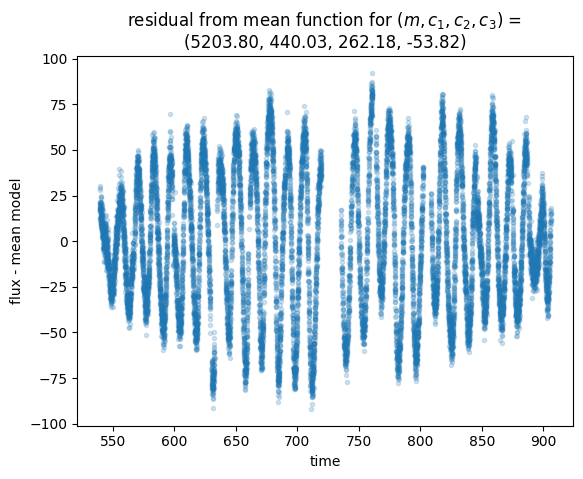

In [7]:
plt.scatter(tab['time'], tab['flux'] - mean_model.get_value(tab['time']), alpha=0.2, marker='.')
plt.title('residual from mean function for ($m, c_1, c_2, c_3$) = '+'\n'+\
          '({:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(q6_mean, q7_mean, q8_mean, q9_mean))
plt.xlabel('time')
plt.ylabel('flux - mean model')

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots) (20 pts)

The priors on $m, c_1, c_2$ and $c_3$ should be bound by the maximum and minimum flux measured in each respective quarter of $\textit{Kepler}$ data. I will define them as Gaussians centered on the mean flux measured in each quarter $\left(\langle\textbf{F}_q\rangle\right)$ with width equal to the standard deviation of the flux in that quarter $\left(\sigma_{q}\right)$. 
\begin{equation}
p(m) = \mathcal{N}\left(\langle\textbf{F}_6\rangle, \sigma_{6}\right) \\
p(c_1) = \mathcal{N}\left(\langle\textbf{F}_7\rangle - \left(\langle\textbf{F}_6\rangle\right), \sigma_{7}\right) \\
p(c_2) = \mathcal{N}\left(\langle\textbf{F}_8\rangle - \left(\langle\textbf{F}_6\rangle+\langle\textbf{F}_7\rangle\right), \sigma_{8}\right) \\
p(c_3) = \mathcal{N}\left(\langle\textbf{F}_9\rangle - \left(\langle\textbf{F}_6\rangle+\langle\textbf{F}_7\rangle+\langle\textbf{F}_8\rangle\right), \sigma_{9}\right)
\end{equation}

<!-- To estimate reasonable priors on the parameters in the kernel, first consider a lag $t_i - t_j = P$. In this case,
\begin{equation}
k(P) = A \cdot \exp\left(\frac{P^2}{\lambda}\right)
\end{equation} -->

In [8]:
@np.vectorize
def k(lag, a, gamma, p, lambd):
    return a*np.exp(-gamma*np.sin(np.pi*abs(lag)/p)**2 - abs(lag)**2/lambd)

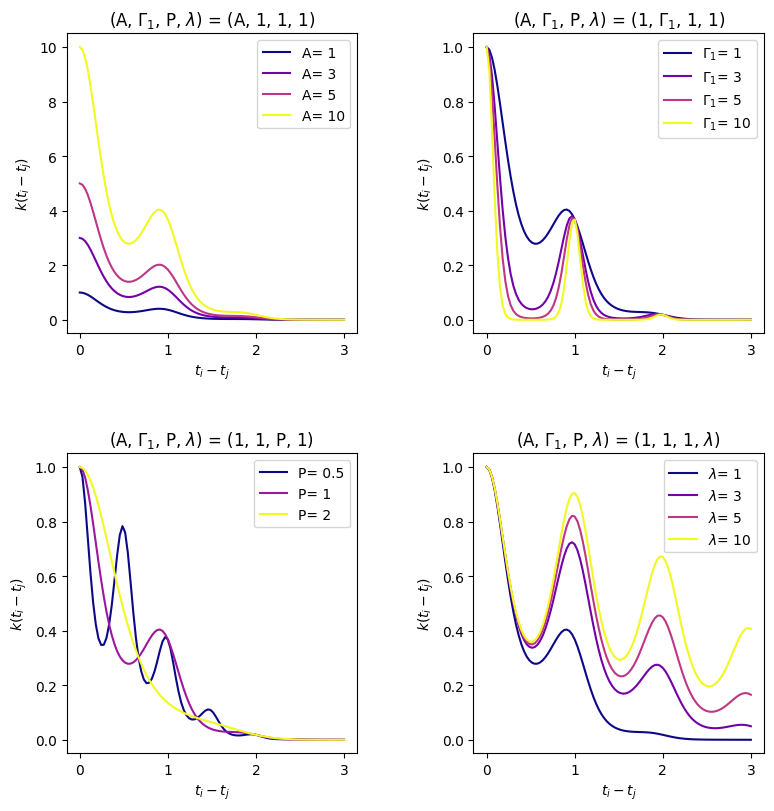

In [9]:
plt.figure(figsize=(9,9), dpi=100)
def kernelplot(subplot_pos, lag, param_name, param_grid):
    kern_dict = {'a':1, 'gamma':1, 'p':1, 'lambd':1}
    label_dict = {'a':'A', 'gamma':r'$\Gamma_1$', 'p':'P', 'lambd':r'$\lambda$'}
    norm = mpl.colors.Normalize(vmin=min(param_grid), vmax=max(param_grid))
    plt.subplot(2, 2, subplot_pos)
    for q in range(len(param_grid)):
        kern_dict[param_name] = param_grid[q]
        plt.plot(lag, k(lag, **kern_dict), c=mpl.cm.plasma(norm(param_grid[q])), 
                 label=label_dict[param_name]+'= {}'.format(str(param_grid[q])))
    plt.xlabel(r'$t_i - t_j$')
    plt.ylabel(r'$k(t_i - t_j)$')
    plt.legend(loc='upper right')
    title_dict = {'a':'(A, 1, 1, 1)', 'gamma':r'(1, $\Gamma_1$, 1, 1)', 'p':'(1, 1, P, 1)', 
                  'lambd':r'(1, 1, 1, $\lambda$)'}
    plt.title(r'(A, $\Gamma_1$, P, $\lambda$) = '+title_dict[param_name])

plt.subplots_adjust(left=0.125,right=0.9,bottom=0.1,top=0.9,wspace=0.4,hspace=0.4)

kernelplot(1, np.linspace(0, 3, 100), 'a', [1, 3, 5, 10])
kernelplot(2, np.linspace(0, 3, 100), 'gamma', [1, 3, 5, 10])
kernelplot(3, np.linspace(0, 3, 100), 'p', [0.5, 1, 2])
kernelplot(4, np.linspace(0, 3, 100), 'lambd', [1, 3, 5, 10])

From the plots above, we can get a sense of what the remaining 4 parameters do. $A$ sets the amplitude, $\Gamma_1$ sets the strength of the correlation between data at non-periodic lag intervals, $P$ is the period of the correlations, and $\lambda$ can be thought of as the relative strength between the exponential sine squared and the exponential squared components of the kernel.

(600.0, 650.0)

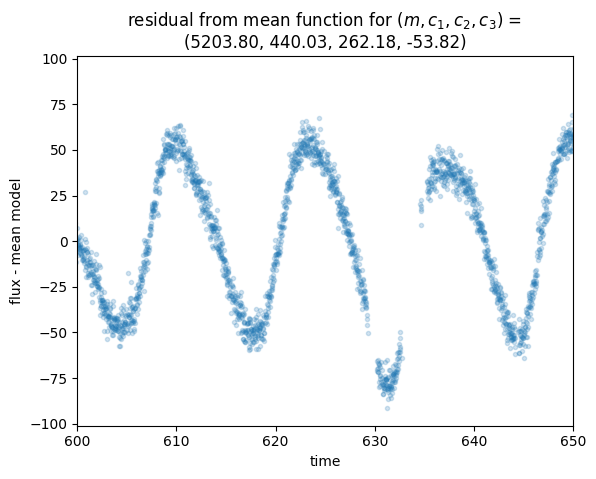

In [10]:
plt.scatter(tab['time'], tab['flux'] - mean_model.get_value(tab['time']), alpha=0.2, marker='.')
plt.title('residual from mean function for ($m, c_1, c_2, c_3$) = '+'\n'+\
          '({:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(q6_mean, q7_mean, q8_mean, q9_mean))
plt.xlabel('time')
plt.ylabel('flux - mean model')
plt.xlim(600, 650)

Looking at a zoomed-in plot of the residual from a mean function, the period is around 15 days, with the amplitude around 50. 

In [11]:
from pandas import Series

In [12]:
s = Series(data=(tab['flux'] - mean_model.get_value(tab['time'])).data,
           index=tab['time'])

In [13]:
@np.vectorize
def autocorr_(lags):
    return s.autocorr(lags)

Text(0, 0.5, 'autocorrelation')

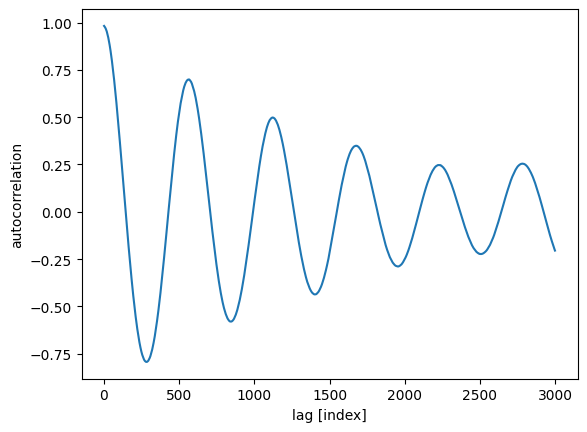

In [14]:
plt.plot(np.arange(1, 3000), autocorr_(np.arange(1, 3000)))
plt.xlabel('lag [index]')
plt.ylabel('autocorrelation')

From the autocorrelation plot above, $\lambda$ seems to be fairly large and $\Gamma_1$ fairly small, though we will use uninformed priors to not restrict too tight, since these parameters are not as intuitive to estimate.

In [15]:
global q6_min, q6_max, q7_min, q7_max, q8_min, q8_max, q9_min, q9_max
q6_min = tab[tab['quarter'] == 6]['flux'].min()
q6_max = tab[tab['quarter'] == 6]['flux'].max()
q7_min = tab[tab['quarter'] == 7]['flux'].min()
q7_max = tab[tab['quarter'] == 7]['flux'].max()
q8_min = tab[tab['quarter'] == 8]['flux'].min()
q8_max = tab[tab['quarter'] == 8]['flux'].max()
q9_min = tab[tab['quarter'] == 9]['flux'].min()
q9_max = tab[tab['quarter'] == 9]['flux'].max()
global q6_std, q7_std, q8_std, q9_std
q6_std = np.std(tab[tab['quarter'] == 6]['flux'])
q7_std = np.std(tab[tab['quarter'] == 7]['flux'])
q8_std = np.std(tab[tab['quarter'] == 8]['flux'])
q9_std = np.std(tab[tab['quarter'] == 9]['flux'])
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)
def log_prior(theta): 
    m, c1, c2, c3, A, gamma, P, lambd = theta
    logp_m = np.log(gaussian(m, q6_mean, q6_std))
    logp_c1 = np.log(gaussian(c1, q7_mean, q7_std))
    logp_c2 = np.log(gaussian(c2, q8_mean, q8_std))
    logp_c3 = np.log(gaussian(c3, q9_mean, q9_std))
    logp_A = np.log(gaussian(A, 50, 25))
    logp_P = np.log(gaussian(P, 15, 5))
    logp_gamma = np.log(gaussian(gamma, 2, 0.5))
    logp_lambd = np.log(gaussian(lambd, 10, 4))
    
    logp = np.sum([logp_m, logp_c1, logp_c2, logp_c3,
                  logp_A, logp_P, logp_gamma, logp_lambd])
    return logp

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps) (20 pts)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help 

In [16]:
def lnprob(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(tab['flux'][::10], quiet=True) + log_prior(p)

In [17]:
# Use code from https://github.com/RuthAngus/GPtutorial/blob/master/Simple_george_demo.ipynb
# to get a decent guess on initial parameters
gp = george.GP(kern(50, 2, 10, 15), mean=mean_model)
gp.compute(tab['time'][::10], tab['error'][::10])

from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(tab['flux'][::10])

result = minimize(neg_ln_like, gp.get_parameter_vector())
print(result.x)

[ 5.21073552e+03  4.27437685e+02  2.73966950e+02 -5.57985799e+01
  7.37831793e+00  2.01766774e+00  1.98217135e+00  1.50363563e+01]


In [18]:
initial = result.x
ndim, nwalkers = len(initial), 16
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running first burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 300, progress=True)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 2000, progress=True);

Running first burn-in...


100%|█████████████████████████████████████████| 300/300 [07:14<00:00,  1.45s/it]


Running production...


100%|███████████████████████████████████████| 2000/2000 [54:19<00:00,  1.63s/it]


In [19]:
import corner

In [20]:
samples = sampler.get_chain(flat=True)

In [29]:
np.save('samples.npy', samples)

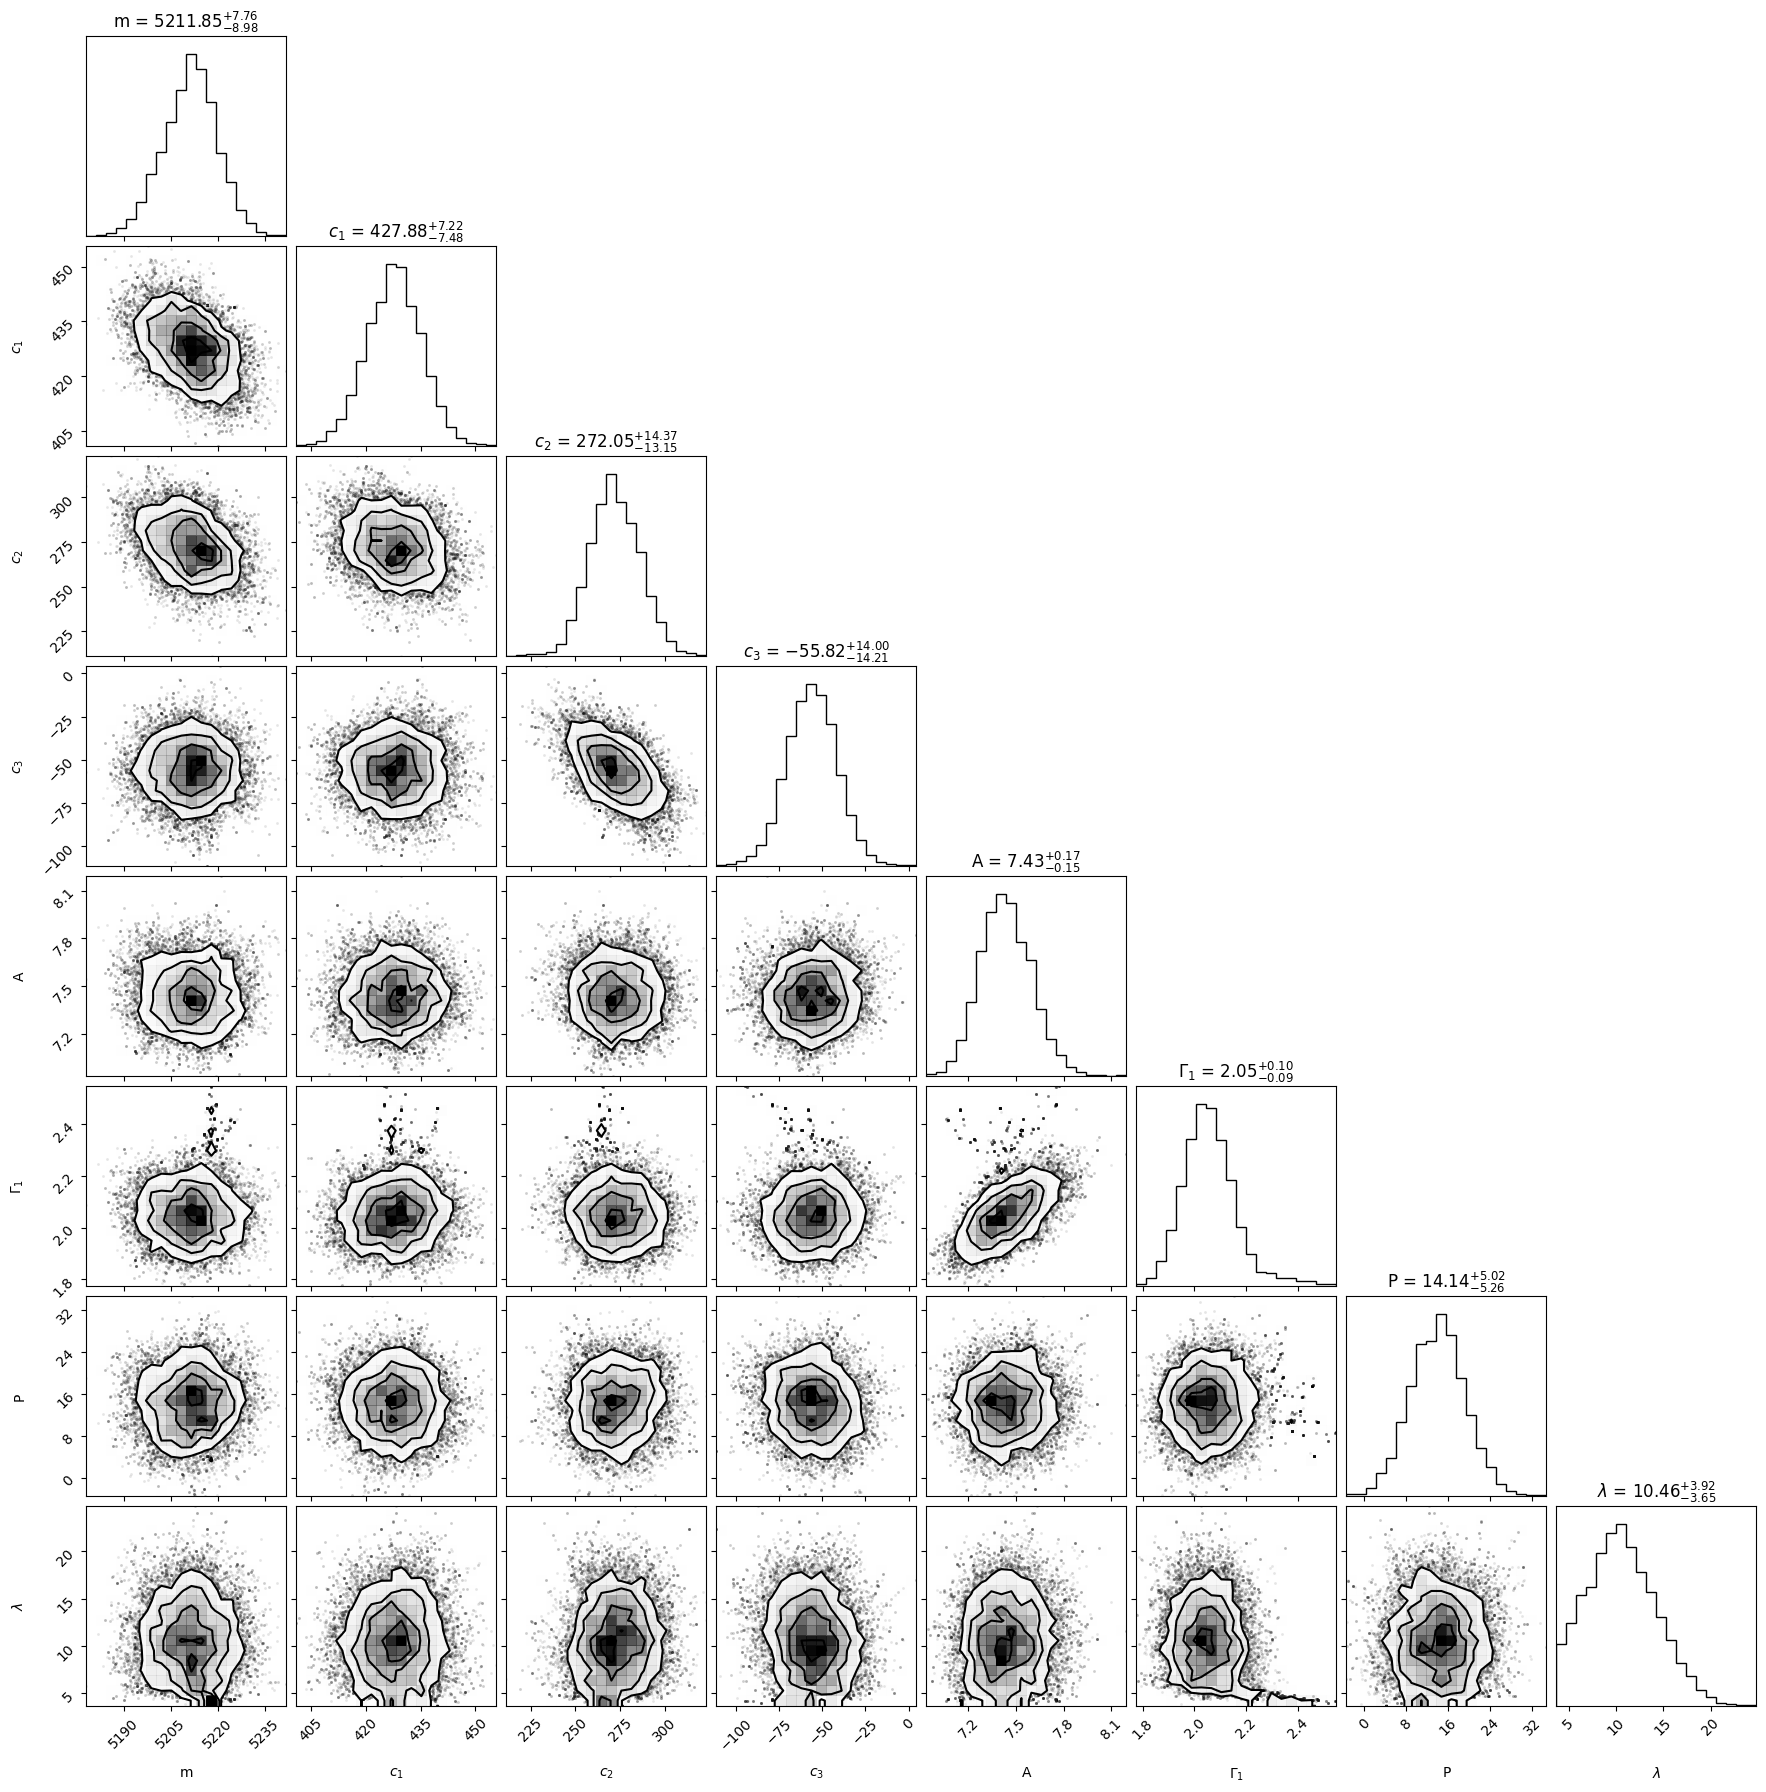

In [34]:
corner.corner(samples, labels=['m', r'$c_1$', r'$c_2$', r'$c_3$', 'A', r'$\Gamma_1$', 'P', r'$\lambda$'],
             show_titles=True);

### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black.  (20 pts)

In [36]:
# plt.scatter(tab['time'][::10], tab['flux'][::10], marker='.', alpha=0.5, color='C0')
# for q in range(1, 5):
#     plt.plot(tab['time'][q::10],
#              gp.sample_conditional(tab['flux'][q::10], tab['time'][q::10]), alpha=0.3, color='C3')
# plt.xlim(550, 625)
# plt.ylim(5000, 5300)

In [1]:
# help(kern(*(gp.get_parameter_vector()[4:])))

In [ ]:
# pred, pred_var = gp.predict(np.concatenate([tab['flux'][i::10] for i in range(1, 10)]), 
#                             np.concatenate([tab['time'][i::10] for i in range(1, 10)]), return_var=True)

In [81]:
pred, pred_var = gp.predict(tab['flux'][1::10], tab['time'][1::10], return_var=True)
pred -= Model(*(gp.get_parameter_vector()[:4])).get_value(tab['time'][1::10])

In [79]:
# plt.plot(pred - Model(*(gp.get_parameter_vector()[:4])).get_value(tab['time'][1::10]))

Text(0.5, 1.0, '(m, $c_1$, $c_2$, $c_3$, A, $\\Gamma_1$, P, $\\lambda$) = \n(5211.81, 442.19, 261.17, -31.96, 7.65, 2.15, 15.94, 9.53)')

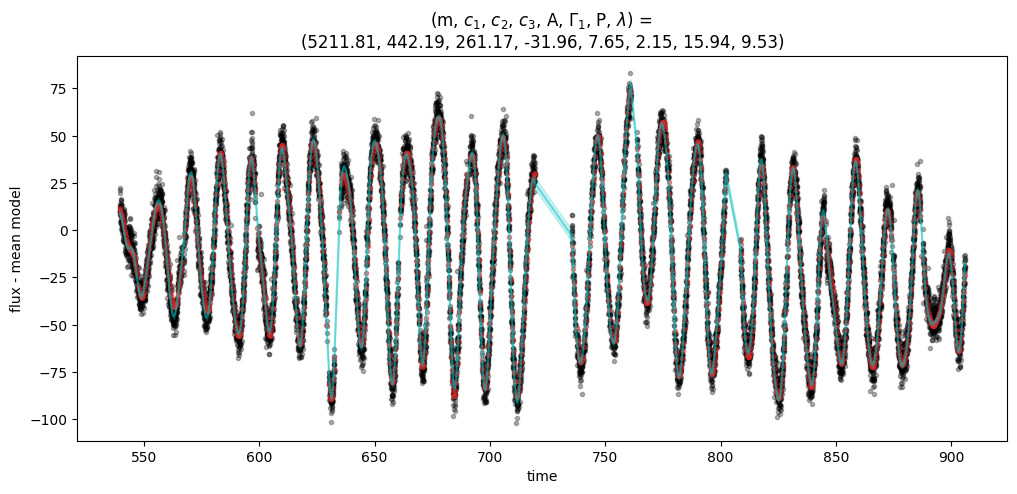

In [84]:
plt.figure(figsize=(12, 5))
plt.scatter(tab['time'][::10],
            gp.sample_conditional(tab['flux'][::10], tab['time'][::10]) -\
            Model(*(gp.get_parameter_vector()[:4])).get_value(tab['time'][::10]), marker='.', color='C3', 
            alpha=0.5, zorder=1)

plt.scatter(np.concatenate([tab['time'][i::10] for i in range(1, 10)]),
            np.concatenate([tab['flux'][i::10] for i in range(1, 10)]) -\
            Model(*(gp.get_parameter_vector()[:4])).get_value(np.concatenate([tab['time'][i::10] for i in range(1, 10)])),
           marker='.', color='k', alpha=0.3, zorder=0)

plt.fill_between(tab['time'][1::10], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="c", alpha=0.2, zorder=2)
plt.plot(tab['time'][1::10], pred, "c", lw=1.5, alpha=0.5, zorder=3)
 
plt.xlabel('time')
plt.ylabel('flux - mean model')
param_vec = gp.get_parameter_vector()
plt.title(r'(m, $c_1$, $c_2$, $c_3$, A, $\Gamma_1$, P, $\lambda$) = '+'\n'+\
         '({:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(param_vec[0],
          param_vec[1], param_vec[2], param_vec[3], 
           param_vec[4], param_vec[5], param_vec[6], param_vec[7]))

And a zoomed-in version of the above plot for clarity

(650.0, 700.0)

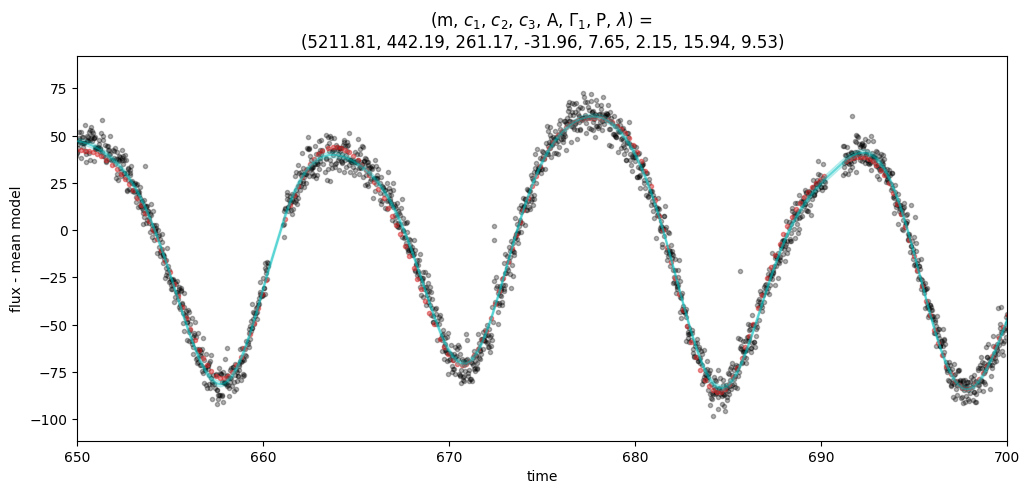

In [85]:
plt.figure(figsize=(12, 5))
plt.scatter(tab['time'][::10],
            gp.sample_conditional(tab['flux'][::10], tab['time'][::10]) -\
            Model(*(gp.get_parameter_vector()[:4])).get_value(tab['time'][::10]), marker='.', color='C3', 
            alpha=0.5, zorder=1)

plt.scatter(np.concatenate([tab['time'][i::10] for i in range(1, 10)]),
            np.concatenate([tab['flux'][i::10] for i in range(1, 10)]) -\
            Model(*(gp.get_parameter_vector()[:4])).get_value(np.concatenate([tab['time'][i::10] for i in range(1, 10)])),
           marker='.', color='k', alpha=0.3, zorder=0)

plt.fill_between(tab['time'][1::10], pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="c", alpha=0.2, zorder=2)
plt.plot(tab['time'][1::10], pred, "c", lw=1.5, alpha=0.5, zorder=3)
 
plt.xlabel('time')
plt.ylabel('flux - mean model')
param_vec = gp.get_parameter_vector()
plt.title(r'(m, $c_1$, $c_2$, $c_3$, A, $\Gamma_1$, P, $\lambda$) = '+'\n'+\
         '({:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(param_vec[0],
          param_vec[1], param_vec[2], param_vec[3], 
           param_vec[4], param_vec[5], param_vec[6], param_vec[7]))
plt.xlim(650, 700)

# P2. Random Forests

For this work, we'll use the datasets produced by [Dey et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.515.5285D/abstract), who trained a deep capsule network on postage stamps of SDSS galaxies to predict photometric redshifts. 

We're not going to use a deep capsule network on postage stamps, but we can use tabular data. This won't be as performant, but it's still instructive to see how well we can do with a simple random forest. Dey et al. have done an excellent job making their data available - http://d-scholarship.pitt.edu/42023/ (all of it)

You will need the [training set](http://d-scholarship.pitt.edu/42023/9/cat_train.csv) and the [test set](http://d-scholarship.pitt.edu/42023/8/cat_test.csv).

I suggest reading through Sec. 2 of the paper to get some sense of what the data is. Importantly, the data includes columns for photometric redshift already. You can't use these to train your random forest (duh.). I've limited the number of columns you can use to a set defined below. If you use more than these (e.g. the GalaxyZoo parameters) you might get better performance at the cost of a smaller training sample because you've also got to filter missing data. 

In [86]:
train_cols = ['dered_petro_u', 'dered_petro_g', 'dered_petro_r', 'dered_petro_i', 'dered_petro_z',\
       'petroMagErr_u', 'petroMagErr_g', 'petroMagErr_r', 'petroMagErr_i', 'petroMagErr_z',\
       'v_disp', 'sersicN_r', 'petroR90_r']
pred_cols  = ['z', 'zErr'] #'bestObjID', 'zphot', 'dzphot'

### Q6. Pre-process the data

All ML work involves some amount of cleaning and pre-processing the data.
Filter data that have `zphot_reliable` == `True`, and have redshifts and photo-zs >= 0. 
Next filter any entries in the `train_cols` that have any value that is > 5 $\times$ the nomrally-scaled Median Absolute Deviation (as described in Sec 2.3) (`scipy.stats.median_abs_deviation` is your friend). 
Your pre-processed training data should have 357397 entries.
Make a hexbin plot of `zphot` vs `z` for the training data (to avoid plotting that many points) but replicate Fig. 3 in Dey et al. 
(35 pts)

In [87]:
#read in the training data
from astropy.table import Table
from scipy.stats import median_abs_deviation
import numpy as np
import matplotlib.pyplot as plt
import pickle
training_data = Table.read('cat_train.csv')

Inspect the data

In [88]:
training_data[:5]

imageID,specObjID,bestObjID,class,subClass,z,zErr,objID,type,flags,ra,dec,l,b,dered_petro_u,dered_petro_g,dered_petro_r,dered_petro_i,dered_petro_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,zphot,dzphot,zphot_avg,zphot_reliable,e_bv_sfd,primtarget,sectarget,targettype,spectrotype,Column1,v_disp,release,bptclass,lgm_tot_p50,sfr_tot_p50,specsfr_tot_p50,oh_p50,logMass_median,ssfr_mean,age_mean,tau_mean,t_age_mean,metallicity_mean,dust1_mean,dust2_mean,EBV,fracDev_r,deVAB_r,deVPhi_r,expAB_r,expPhi_r,petroR90_r,deVRad_r,expRad_r,probPSF_r,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,modelMagErr_u,modelMagErr_g,modelMagErr_r,modelMagErr_i,modelMagErr_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z,cModelMagErr_u,cModelMagErr_g,cModelMagErr_r,cModelMagErr_i,cModelMagErr_z,dr7ObjID,zmean_cnn,zmed_cnn,zpeak_cnn,idx_Kcorr,d2d,absMag_u,absMag_g,absMag_r,absMag_i,absMag_z,absMagErr_u,absMagErr_g,absMagErr_r,absMagErr_i,absMagErr_z,sersicN_u,sersicN_g,sersicN_r,sersicN_i,sersicN_z,gz1Morpho,p_el_debiased,p_cs_debiased,p_el,p_cs,p_mg,p_dk,P_disk,P_edge_on,P_bar_GZ2,P_bulge,P_cigar,P_merg,P_bar_Nair10,TT_pred,P_S0
int64,int64,int64,str6,str21,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,int64,str17,str6,str21,float64,str12,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
604197,3109758158738843648,1237668333638516913,GALAXY,--,0.11518704891204834,2.1644211301463656e-05,1237668333638516913,3,35253360136720,220.34014174421623,15.68592233606349,14.40863696032929,62.06072893804778,19.86393165588379,17.97071075439453,17.06884765625,16.704151153564453,16.356016159057617,0.16745492815971375,0.011386794969439507,0.008139836601912975,0.010684128850698471,0.030685000121593475,0.09745699912309647,0.013516999781131744,0.09579700231552124,1,0.024069081991910934,64,0,GALAXY,GALAXY,--,154.91680908203125,dr7.2,-1,10.806196212768555,-1.2120749950408936,-12.061046600341797,-9999.0,10.773570860923835,-12.027894629038649,3.1181009167270504,0.1332879457983001,3.3307511864094455,0.009020637328951886,1.0478653803895055,0.34893918334238455,0.024025,1.0,0.6889982223510742,166.96804809570312,0.7907353043556213,164.26400756835938,4.535552501678467,1.4974050521850586,1.0204849243164062,0.0,0.12407521903514862,0.09129336476325989,0.06621356308460236,0.05020773783326149,0.03559791296720505,20.01227,18.06196,17.122870000000002,16.727829999999997,16.41084,0.06787479,0.006897906999999999,0.005152807,0.005692544,0.01341846,20.23943,18.04506,17.12286,16.74396,16.37709,0.06716295,0.006896235,0.005152805999999999,0.005693586,0.0134191,587742575920283726,0.11268118768930435,0.11114189028739929,0.11222222447395325,2377592.0,0.09587623055375255,-18.449764251708984,-20.237857818603516,-20.93724250793457,-21.21788787841797,-21.4788818359375,0.0918397307395935,0.02135663665831089,0.02073599211871624,0.02108471654355526,0.033089883625507355,5.90333366394043,4.75451135635376,3.751222848892212,3.606508255004883,4.197576999664307,--,--,--,0.625,0.28099998831749,0.0,0.0939999967813492,2.0024376681249123e-06,0.0008818753995001316,0.006049769930541515,0.8819934725761414,0.0029378612525761127,0.11407507210969925,0.34805

In [89]:
def nmad(column):
    '''Dey et al. 2022 definition of normalized median absolute deviation'''
    return 1.4826*median_abs_deviation(column)

In [90]:
# define a filter to clean and pre-process the data
def filter_data(table):
    filt = (table['zphot_reliable'] == True) 
    filt &= (table['zphot'] >= 0.) 
    for col_name in train_cols:
        filt &= (table[col_name] - np.mean(table[col_name]) < 5.*nmad(table[col_name]))
    return table[filt]

In [91]:
filtered_training_data = filter_data(training_data)

In [92]:
filtered_td_pd = filtered_training_data.to_pandas()

In [95]:
dropnans = filtered_td_pd[train_cols+pred_cols+['zphot', 'dzphot']].dropna()

In [96]:
len(dropnans)

379882

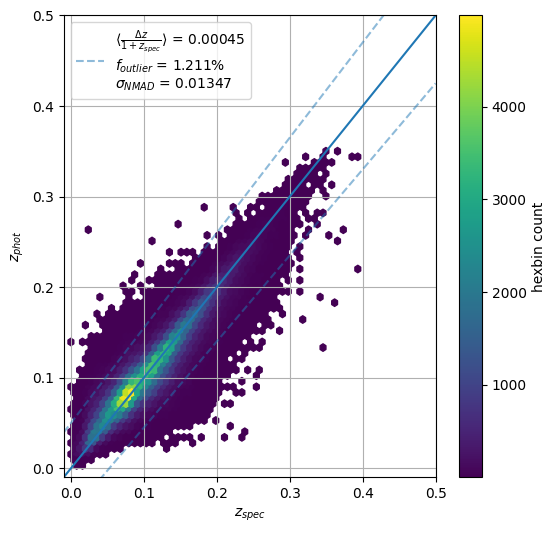

In [97]:
plt.figure(figsize=(6,6),dpi=100)
plt.hexbin(x=dropnans['z'], y=dropnans['zphot'],gridsize=50,cmap='viridis',mincnt=1)
plt.colorbar(label='hexbin count')
plt.xlabel(r'$z_{spec}$')
plt.ylabel(r'$z_{phot}$')
gca = plt.gca()
xlims = [-0.01, 0.5]
ylims = [-0.01, 0.5]
plt.plot(xlims, ylims, color='C0') #label=r'$z_{spec}$ = $z_{phot}$',
offsets = (dropnans['zphot'] - dropnans['z'])/(1.+dropnans['z'])
mean_offset = np.mean(offsets)
f_outlier = len(np.where(abs(offsets) > 0.05)[0])/len(offsets)
plt.plot(xlims, np.array(ylims) - 0.05*(1.+np.array(ylims)), color='C0', alpha=0.5, linestyle='--',
        label=r'$\langle\frac{\Delta z}{1+z_{spec}}\rangle$ = '+'{:.5f}'.format(mean_offset)+'\n'+\
        r'$f_{outlier}$ = '+'{:.3f}'.format(f_outlier*100.)+'%'+'\n'+\
        r'$\sigma_{NMAD}$ = '+'{:.5f}'.format(nmad(offsets - np.median(offsets)))) 
#r'$\left|\frac{\Delta z}{1+z_{spec}}\right| = 0.05$'+'\n'+\
plt.plot(xlims, np.array(ylims) + 0.05*(1.+np.array(ylims)), color='C0', alpha=0.5, linestyle='--')
plt.xlim(xlims)
plt.ylim(ylims)
plt.grid()
plt.legend(loc='upper left')
plt.show()

### Q7. Train the forest(s)

Using `n_estimators` (i.e. number of trees) in (5, 20, 50, 200, 500), train a random forest. You can use all the cores your CPU has with `n_jobs=-1`. Limit the maximum number of features at each branch with `sqrt`. Use the inverse variance of the redshifts as your sample weights. Plot the `oob_score` vs the number of trees. For each of the forests you trained, make a plot of the feature importances. (35 pts)

Note, on this last run before submitting, I could not get n=500 to run in time, but in previous tests, I found that the OOB score was around the same, barely larger, than for n=200.

In [98]:
from sklearn.ensemble import RandomForestRegressor

In [102]:
oob_dict = {}
fi_dict = {}
rfr_dict = {}
for n_est in [5, 20, 50, 200, 500]:
    rfr = RandomForestRegressor(n_estimators=n_est, max_features='sqrt', random_state=42, n_jobs=-1,
                                   oob_score=True)
    rfr.fit(dropnans[train_cols],
       dropnans[pred_cols],
       dropnans['zErr']**-2)
    rfr_dict[str(n_est)] = rfr
    oob_dict[str(n_est)] = rfr.oob_score_
    fi_dict[str(n_est)] = rfr.feature_importances_

In [103]:
oob_dict

{'5': 0.1327634088637224,
 '20': 0.7302756097987748,
 '50': 0.7576011326741108,
 '200': 0.7695406979203776}

Text(0.5, 0, 'n estimators')

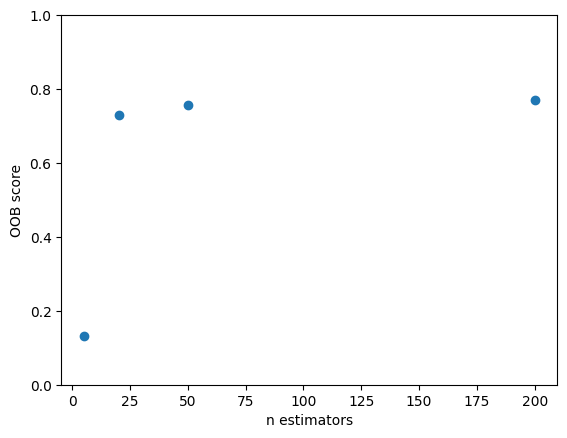

In [104]:
nest_list = [5, 20, 50, 200]#, 500]
plt.figure()
plt.scatter(nest_list, [oob_dict[str(n)] for n in nest_list])
plt.ylim(0, 1)
plt.ylabel('OOB score')
plt.xlabel('n estimators')

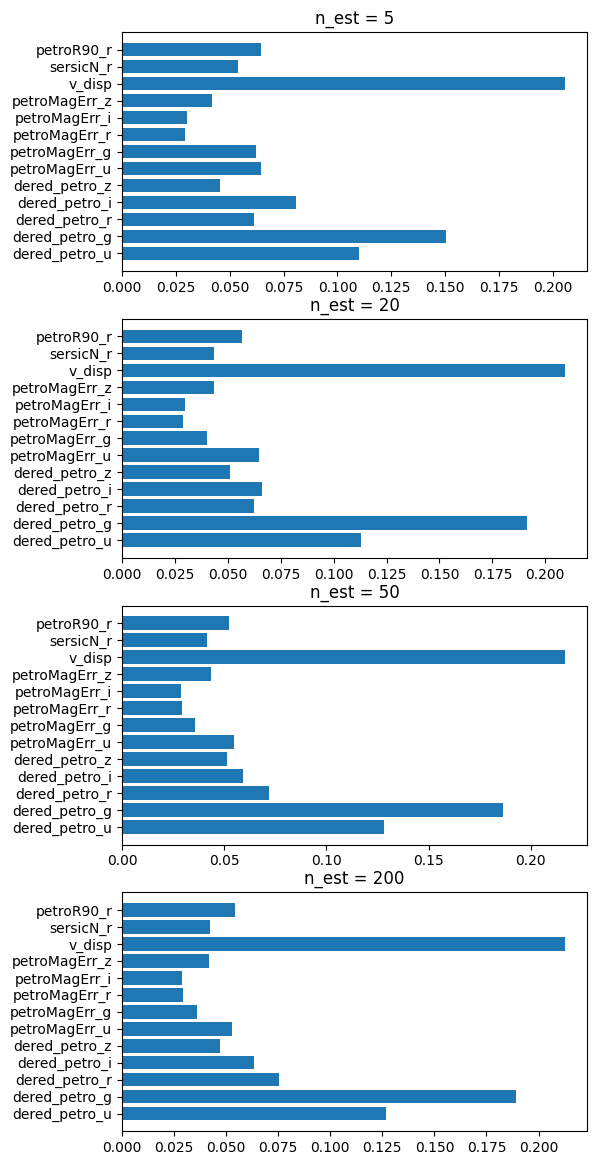

In [105]:
plt.figure(figsize=(6,18), dpi=100)
i = 1
for which_rfr in rfr_dict.keys():
    plt.subplot(5,1,i)
    plt.barh(train_cols, fi_dict[str(which_rfr)]);
    plt.title(f'n_est = {which_rfr}')
    i += 1
    #plt.xticks(rotation=90);

### Q8. Test.

Pick your best performing forest from Q7. Load the test data (remember to apply any cuts you did to the training data). Use your random forest to predict the photo-z. Replicate Fig. 3 and Fig. 4 with your photo-z prediction *and* the photo-z prediction from SDSS included in the file. (30 pts, 10 pts for prediction, 10 for the two figures)

The best performing forest is n=500, but it doesn't have a great increase in OOB score over n=200.

In [106]:
test_data = Table.read('cat_test.csv')

In [107]:
filtered_test_data = filter_data(test_data)
filtered_test_pd = filtered_test_data.to_pandas()

In [108]:
dropna_test = filtered_test_pd[train_cols+pred_cols+['zphot', 'dzphot']].dropna()
predicted = rfr_dict['200'].predict(dropna_test[train_cols])

In [109]:
pred_cols

['z', 'zErr']

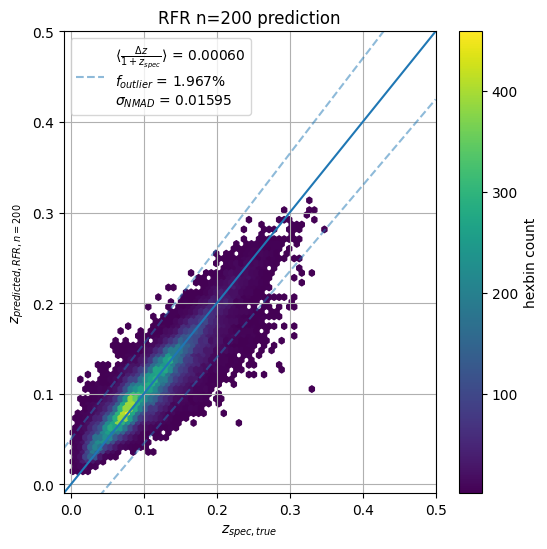

In [141]:
plt.figure(figsize=(6,6),dpi=100)
plt.hexbin(x=dropna_test['z'], y=predicted[:,0],gridsize=50,cmap='viridis',mincnt=1)
plt.colorbar(label='hexbin count')
plt.xlabel(r'$z_{spec, true}$')
plt.ylabel(r'$z_{predicted, RFR, n=200}$')
gca = plt.gca()
xlims = [-0.01, 0.5]
ylims = [-0.01, 0.5]
plt.plot(xlims, ylims, color='C0') #label=r'$z_{spec}$ = $z_{phot}$',
offsets = (predicted[:,0] - dropna_test['z'])/(1.+dropna_test['z'])
mean_offset = np.mean(offsets)
f_outlier = len(np.where(abs(offsets) > 0.05)[0])/len(offsets)
plt.plot(xlims, np.array(ylims) - 0.05*(1.+np.array(ylims)), color='C0', alpha=0.5, linestyle='--',
        label=r'$\langle\frac{\Delta z}{1+z_{spec}}\rangle$ = '+'{:.5f}'.format(mean_offset)+'\n'+\
        r'$f_{outlier}$ = '+'{:.3f}'.format(f_outlier*100.)+'%'+'\n'+\
        r'$\sigma_{NMAD}$ = '+'{:.5f}'.format(nmad(offsets - np.median(offsets)))) 
#r'$\left|\frac{\Delta z}{1+z_{spec}}\right| = 0.05$'+'\n'+\
plt.plot(xlims, np.array(ylims) + 0.05*(1.+np.array(ylims)), color='C0', alpha=0.5, linestyle='--')
plt.xlim(xlims)
plt.ylim(ylims)
plt.grid()
plt.legend(loc='upper left')
plt.title('RFR n=200 prediction')
plt.show()

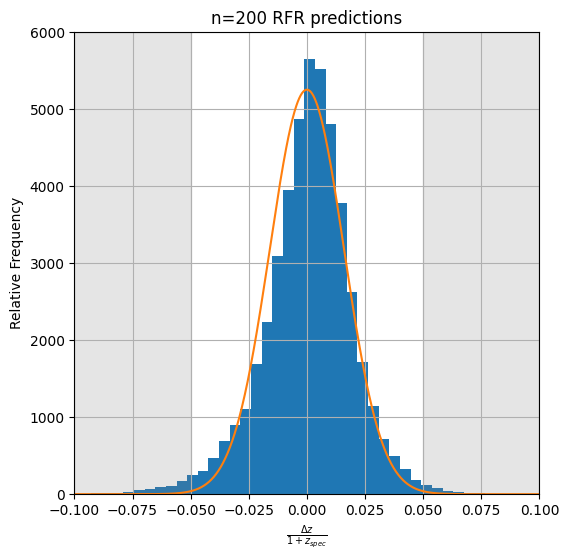

In [143]:
plt.figure(figsize=(6,6),dpi=100)

plt.xlabel(r'$\frac{\Delta z}{1+z_{spec}}$')
plt.ylabel(r'Relative Frequency')

plt.hist(offsets, bins=60)
gaus_arr = np.linspace(-0.1, 0.1, 1000)
plt.plot(gaus_arr, 210*gaussian(gaus_arr, 0, nmad(offsets - np.median(offsets))))

plt.fill_between([0.05, 0.05, 0.1, 0.1], [0, 6000, 6000, 0], color='grey', alpha=0.2)
plt.fill_between([-0.05, -0.05, -0.1, -0.1], [0, 6000, 6000, 0], color='grey', alpha=0.2)
plt.ylim(0, 6000)
plt.xlim(-0.1, 0.1)
plt.grid()
plt.title('n=200 RFR predictions')
plt.show()

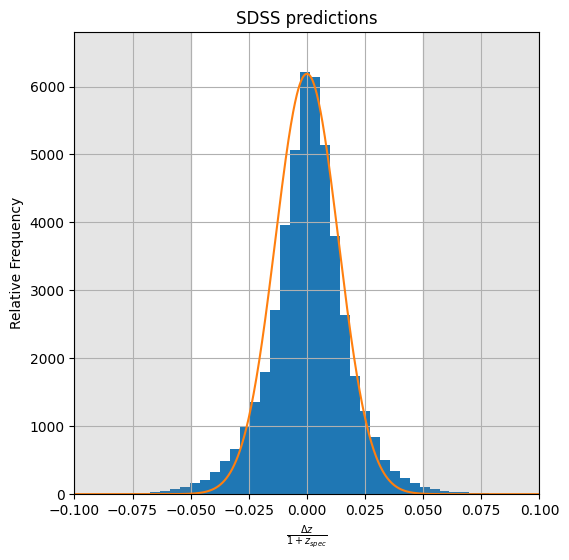

In [144]:
sdss_offsets = offsets = (dropna_test['zphot'] - dropna_test['z'])/(1.+dropna_test['z'])
plt.figure(figsize=(6,6),dpi=100)

plt.xlabel(r'$\frac{\Delta z}{1+z_{spec}}$')
plt.ylabel(r'Relative Frequency')

plt.hist(sdss_offsets, bins=60)
gaus_arr = np.linspace(-0.1, 0.1, 1000)
plt.plot(gaus_arr, 210*gaussian(gaus_arr, 0, nmad(sdss_offsets - np.median(sdss_offsets))))

plt.fill_between([0.05, 0.05, 0.1, 0.1], [0, 6800, 6800, 0], color='grey', alpha=0.2)
plt.fill_between([-0.05, -0.05, -0.1, -0.1], [0, 6800, 6800, 0], color='grey', alpha=0.2)
plt.ylim(0, 6800)
plt.xlim(-0.1, 0.1)
plt.grid()
plt.title('SDSS predictions')
plt.show()